# <font  color = "#0093AF">Cross-Effect</font>

The cross-effect$^{1,2}$ is a powerful approach to DNP enhancement, where two coupled electrons with resonance frequencies separated by the nuclear Larmor frequency undergo a three-spin flip with the electron.

$$
\begin{equation}
\pm\omega_n=\omega_{e1}-\omega_{e2}
\end{equation}
$$

Enhancement on the nucleus is induced if the polarization of the two electrons is different. This is achieved by applying a saturating field to the electrons, such that one becomes more saturated than the other.

Most orientations of electron pairs in the sample do not match the above condition, however, magic angle spinning will bring most crystallites through the cross-effect matching condition at some point in the rotor period,$^3$ allowing cross effect to be an effective mechanism of enhancement. Other processes also occur: MAS will cause both electrons to get saturated at various points during the rotor period, and electron-electron transfer without involving the nucleus occurs when the two electrons have the same resonance frequency at some point during the rotor period. We investigate these various processes here.

[1] A.V. Kessenikh, V.L. Luschikov, A.A. Manenkov, Y. Taran. *Sov. Phys. Solid State*, **1963**, 6, 321-329

[2] C.F. Hwang, D.A. Hill. [*Phys. Rev. Lett.*](https://doi.org/10.1103/PhysRevLett.19.1011), **1967**, 19, 1011-1014.

[3] K.R. Thurber, R. Tycko. [*J. Chem. Phys.*](https://doi.org/10.1063/1.4747449), **2012**, 137, 084508.

## Setup

In [2]:
# SETUP SLEEPY
import os
os.chdir('../../../')

In [3]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
from time import time

## Calculate a spectrum of one crystallite under MAS

Something important to understand about cross-effect (and simulating it) is that by spinning the sample at a frequency much slower than the range of the electron resonance frequencies sampled during the rotor period, we do not average the electron resonance frequence. Instead, we sample many different frequencies. In our example here, the electron covers a range of frequencies about 600 MHz broad. This results in a broad spectrum of frequencies for single orientations.

A few important points: 

1. In reality, the sampling of frequencies by MAS is continuous, but in simulation it is discretized. Then, narrow conditions may be missed in simulation that would be briefly met in reality. This can be dealt with by increasing the number of gamma angles, or by decreasing $T_2$ which should broaden conditions.

2. A spectrum with many frequencies results from a single crystallite under MAS, although it is not phaseable. This is because different frequencies are sampled at different times during the rotor period, where the magnetization is not always starting along the x-axis, thus resulting in a varying phase.

3. To obtain the full breadth of the spectrum, we spin faster than typical DNP experiments, and then sample many times in the rotor period (faster spinning allows us to sample less in one rotor period, yielding a faster simulation).

In [4]:
# This is a trick to adjust the electron carrier frequency
# to be centered on the middle of the g-tensor
gxx,gyy,gzz=2.0021,2.0061,2.0094
sl.Constants['ge']=(gxx+gyy+gzz)/3

State-space reduction: 4->1
Prop: 10000 steps per every 1 rotor period


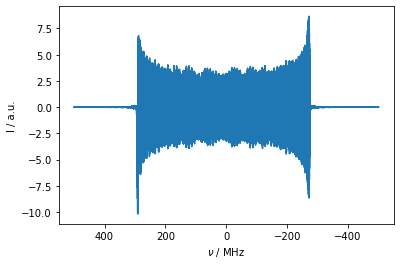

In [5]:
ex=sl.ExpSys(v0H=250,Nucs='e-',LF=False,vr=100000,T_K=80,pwdavg='alpha0beta45',n_gamma=200)
ex.set_inter('g',i=0,gxx=gxx,gyy=gyy,gzz=gzz,euler=[0,0,0])

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=50e-6,OS=True)
L.add_relax('T1',i=0,T1=250e-6,OS=True,Thermal=True)

seq=L.Sequence()

rho=sl.Rho('ex','ep')
rho.DetProp(seq,n=10000,n_per_seq=10000)

_=rho.plot(FT=True,axis='MHz')

Then, we obtain a broad spectrum from the single orientation, but its phase is random. We can plot the power spectrum to get a better view (there is no built-in function for this, but it is trivial to obtain, since the Fourier-transformed spectrum is in `rho.FT`). Note that this does not yield the static spectrum; this would require an average over $\beta$-angles.

Text(0.5, 0, '\\nu / MHz')

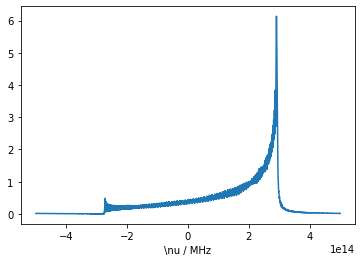

In [6]:
ax=plt.subplots()[1]
rho.apodize=True
rho.apod_pars['LB']=200000
ax.plot(rho.v_axis*1e6,np.abs(rho.FT[0]))
ax.set_xlabel(r'\nu / MHz')

## Cross-effect events as a function of the rotor cycle

### Build the System

It is also important to put the nucleus, but not the electrons, in the lab frame for cross-effect to occur. Some broadening on the electrons is also important, since the cross-effect condition is otherwise too narrow and will be missed during the rotor period.

In the first simulation, we will just look at one rotor period to observe the cross-effect transfer. Note that $T_2$ relaxation added to the nucleus should be applied with the orientation-specific option (`OS=True`), since the nucleus is tipped away from the z-axis. If this is not used, some of the $T_2$ relaxation will be applied to the nuclear polarization.

We take some parameters from Thurber and Tycko.$^1$

[1] K.R. Thurber, R. Tycko. [*J. Chem. Phys.*](https://doi.org/10.1063/1.4747449), **2012**, 137, 084508.

In [18]:
# Note that I have adjusted n_gamma large enough that the enhancement does
# not change with further increases
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=[False,False,True],
             vr=5000,T_K=80,pwdavg='alpha0beta45',n_gamma=1000)
delta=18e6
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=0,gxx=gxx,gyy=gyy,gzz=gzz,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=[0,75*np.pi/180,0])
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

L=ex.Liouvillian()

L.add_relax('T2',i=0,T2=4e-6)
L.add_relax('T2',i=1,T2=4e-6)
_=L.add_relax('T2',i=2,T2=0.2e-3,OS=True)

### Run the simulation

In [33]:
seq=L.Sequence().add_channel('e',v1=500e3,voff=-50e6)

ON=sl.Rho('Thermal',['S0z','S1z','1Hz'])
_=ON.DetProp(seq,n=1000,n_per_seq=1000)

Prop: 1000 steps per every 1 rotor period


### Plot the results

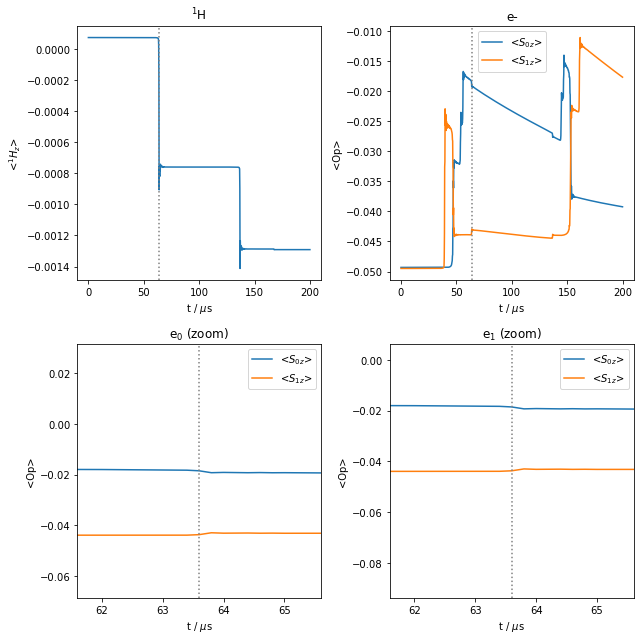

In [34]:
ax=plt.subplots(2,2,figsize=[9,9])[1].flatten()
ON.plot(axis='us',det_num=2,ax=ax[0])
ON.plot(axis='us',det_num=[0,1],ax=ax[1])
i=np.argmax(np.abs(np.diff(ON.I[2]))) #Find the largest change in the nuclear polarization
ON.plot(axis='us',det_num=[0,1],ax=ax[2])
w=10
h=.05
ax[2].set_xlim(ON.t_axis[[i-w,i+w]]*1e6)
ax[2].set_ylim(ON.I[0][i].real+np.array([-h,h]))
ON.plot(axis='us',det_num=[0,1],ax=ax[3])
ax[3].set_xlim(ON.t_axis[[i-w,i+w]]*1e6)
ax[3].set_ylim(ON.I[1][i].real+np.array([-h,h]))

for a,title in zip(ax,[r'$^1$H','e-',r'e$_0$ (zoom)',r'e$_1$ (zoom)']):
    a.set_ylim(a.get_ylim())
    a.set_title(title)
    a.plot(ON.t_axis[i]*1e6*np.ones(2),a.get_ylim(),color='grey',linestyle=':')
ax[0].figure.tight_layout()

In the above plots, we can see where cross effect occurs based on where the $^1$H polarization changes (upper left). The largest such event is marked by a dashed line in all plots. In the upper right plot, we see the behavior of the two electrons. The first event in this plot is partial saturation of $\langle S_{1z}\rangle$. This is followed closely by an exchange of magnetization between the two electrons, where $\omega_{e1}=\omega_{e2}$. Next, saturation of $\langle S_{0z}\rangle$ occurs, followed by the first cross effect event, marked by a dashed line. This event is zoomed in on in the lower two plots. A second cross-effect event occurs next. The final event is further saturation of $\langle S_{1z}\rangle$.

We can continue with this system, adding $T_1$ relaxation to the spins, and propagating over many rotor periods to see the net buildup of polarization.

## Polarization build up over many rotor cycles

### Add $T_1$ relaxation
Don't forget to use `OS=True` to ensure correct relaxation of the mixed nuclear states. We also need thermalization for DNP enhancement to occur (`Thermal=True`).

In [21]:
L.add_relax('T1',i=0,T1=250e-6,OS=True,Thermal=True)
L.add_relax('T1',i=1,T1=250e-6,OS=True,Thermal=True)
_=L.add_relax('T1',i=2,T1=10,OS=True,Thermal=True)

### Run the simulation

In [22]:
seq=L.Sequence().add_channel('e',v1=500e3,voff=-150e6)
ON=sl.Rho('Thermal',['S0z','S1z','1Hz'])
_=ON.DetProp(seq,n=500)

### Plot the results

<AxesSubplot:xlabel='t / ms', ylabel='<$^{1}H_z$>'>

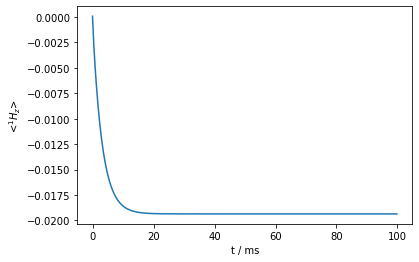

In [23]:
ON.plot(det_num=2)

In [24]:
print(f'Enhancement: {ON.I[-1][-1].real/ex.Peq[-1]:.0f}')

Enhancement: -258


A significant nuclear enhancement is achieved. However, it is interesting to note what happens if the electron saturation is removed, since the cross-effect condition is still met during the rotor cycle, even without microwaves.

In [25]:
seq=L.Sequence()
OFF=sl.Rho('Thermal',['S0z','S1z','1Hz'])
_=OFF.DetProp(seq,n=500)

State-space reduction: 64->24


<AxesSubplot:xlabel='t / ms', ylabel='<$^{1}H_z$>'>

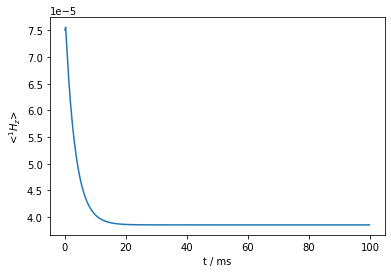

In [26]:
OFF.plot(det_num=2)

In [27]:
print(f'Apparent enhancement: {ON.I[-1][-1].real/OFF.I[-1][-1].real:.0f}')

Apparent enhancement: -503


The $^1$H polarization is depleted when no microwave irradiation is applied. 

Then, if the enhancement is determined by comparing on and off signal, we will significantly overestimate the enhancement. This effect can be understood by noting that even without microwave irradiation, the cross effect condition is periodically met, and if the electrons are not at their own thermal equilibrium at that point, then polarization can be lost from the nucleus.

## One rotor cycle without microwaves
We simulate one rotor cycle without microwaves to observe the trajectory of the nuclear and electronic magnetization.

In [36]:
OFF=sl.Rho('Thermal',['S0z','S1z','1Hz'])
_=OFF.DetProp(seq,n=1000,n_per_seq=1000)

State-space reduction: 64->24
Prop: 1000 steps per every 1 rotor period


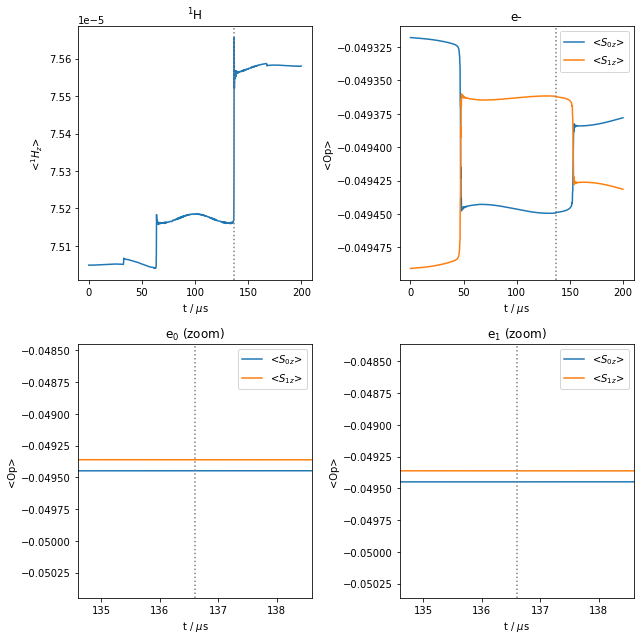

In [37]:
ax=plt.subplots(2,2,figsize=[9,9])[1].flatten()
OFF.plot(axis='us',det_num=2,ax=ax[0])
OFF.plot(axis='us',det_num=[0,1],ax=ax[1])
i=np.argmax(np.abs(np.diff(OFF.I[2]))) #Find the largest change in the nuclear polarization
OFF.plot(axis='us',det_num=[0,1],ax=ax[2])
w=10
h=.001
ax[2].set_xlim(OFF.t_axis[[i-w,i+w]]*1e6)
ax[2].set_ylim(OFF.I[0][i].real+np.array([-h,h]))
OFF.plot(axis='us',det_num=[0,1],ax=ax[3])
ax[3].set_xlim(OFF.t_axis[[i-w,i+w]]*1e6)
ax[3].set_ylim(OFF.I[1][i].real+np.array([-h,h]))

for a,title in zip(ax,[r'$^1$H','e-',r'e$_0$ (zoom)',r'e$_1$ (zoom)']):
    a.set_ylim(a.get_ylim())
    a.set_title(title)
    a.plot(OFF.t_axis[i]*1e6*np.ones(2),a.get_ylim(),color='grey',linestyle=':')
ax[0].figure.tight_layout()

Above, we see that although no saturating field is applied to the electron, the electron polarization still varies throughout the rotor period. This is partly because the thermal equilibrium for the electron polarization changes throughout the rotor period, which is observed as slow variation of the electron polarization (it is important to use `OS=True` and `Thermal=True` to obtain this behavior), and secondly because when the electrons having matching frequencies, they exchange polarization. Then, due to different electron polarizations, the nucleus will lose polarization when the cross effect condition is matched.